In [ ]:
import toml
from sqlalchemy import create_engine
import pandas as pd
from konlpy.tag import Okt
from tqdm import tqdm, tqdm_notebook
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

In [ ]:
config = toml.load("../config/crawler_config.toml")
db_url = 'mysql://' + config['db']['user'] + ':' + config['db']['password'] + '@' + config['db']['host'] \
                            + '/' + config['db']['db'] + '?charset=utf8'
engine = create_engine(db_url, encoding='utf-8')
conn = engine.connect()

In [3]:
articles_df = pd.read_sql_table('articles', con=conn)

In [4]:
# str to Datetime
articles_df.upload_time = articles_df.upload_time.map(lambda x: x.replace('오전', 'AM') if '오전' in x else x.replace('오후', 'PM'))
articles_df.upload_time = pd.to_datetime(articles_df.upload_time, format="%Y.%m.%d. %p %I:%M")

In [5]:
# Delete stop sentences function
stop_sentences = ['▶ ‘코로나19 팩트체크’ 제대로 알아야 이긴다', 
                  '▶ 우리 동네 무article슨 일이? KBS지역뉴스', 
                  '▶ 더 빠르고 정확한 소식을 원하시면 KBS뉴스 구독!']
def delete_stop(content: str) -> str:
    for stop_sen in stop_sentences:
        content = content.replace(stop_sen, '')
    return content

In [6]:
# Delete stop_sentences
articles_df['content'] = articles_df.content\
    .progress_apply(lambda x: delete_stop(x))

In [7]:
# make content phrases token
okt = Okt()
articles_df['content_phrases'] = articles_df.progress_apply(lambda x: okt.phrases(x.content), axis=1)

In [8]:
# make title phrases token
articles_df['title_phrases'] = articles_df.progress_apply(lambda x: okt.phrases(x.title), axis=1)

In [9]:
# save dataframe
articles_df.to_pickle("./article.pkl")

In [ ]:
# read dataframe
articles_df = pd.read_pickle("./article.pkl")

In [22]:
def set_words_per_article(phrases: list) -> list:
    return list(set(phrases))

In [43]:
words_in_article = []
words_in_article += articles_df.content_phrases.progress_apply(lambda x: set_words_per_article(x))

In [46]:
import numpy as np
words_in_article = np.array(words_in_article)

In [69]:
# 2D array to 1D
words_in_article = np.hstack(words_in_article)

In [68]:
list(words_in_article)

In [73]:
from collections import Counter
counts_words_in_article = Counter(words_in_article)

In [87]:
# make dataframe from counts words in articles
phrases_count_df = pd.DataFrame.from_dict(dict(counts_words_in_article), orient="index", columns = ['count'])

In [88]:
# Result of high frequency phrases in total articles
phrases_count_df = phrases_count_df.sort_values('count', ascending=False)
phrases_count_df.head(100)

,count
기자,7102
KBS,5035
코로나,4052
19,4031
오늘,3327
코로나19,3311
뉴스,2727
앵커,2684
KBS 뉴스,2529
보기,2514


In [89]:
# delete stop words(meaningless words)
stop_words = ['기자', 'KBS', '19', '오늘', '뉴스', '앵커', 'KBS 뉴스', '보기', '리포트', '출처', '사진', '사진 출처', '최신', '최신 기사 보기']
for word in stop_words:
    phrases_count_df = phrases_count_df.drop(word)
phrases_count_df.head(100)

,count
코로나,4052
코로나19,3311
확산,2407
우려,2315
지역,2220
지난,2212
위해,2185
코로나19 확산,2077
기사,1954
코로나19 확산 우려,1854


In [92]:
articles_df['positive'] = articles_df['good'] + articles_df['warm']
articles_df['positive'].head()

0    178
1     36
2      1
3      0
4    291
Name: positive, dtype: int64

In [93]:
articles_df['negative'] = articles_df['sad'] + articles_df['angry']
articles_df['negative'].head()

0      7
1    134
2      0
3      0
4    428
Name: negative, dtype: int64

In [100]:
articles_df.loc[articles_df.negative == 0, 'negative']= 1
articles_df['positive/negative'] = articles_df['positive'] / articles_df['negative']
articles_df['positive/negative'].head()

0    25.428571
1     0.268657
2     1.000000
3     0.000000
4     0.679907
Name: positive/negative, dtype: float64

In [102]:
articles_df_pos_neg = articles_df[['positive/negative', 'content_phrases']]
articles_df_pos_neg.head()

,positive/negative,content_phrases
0,25.428571,"[코로나19, 43만, 43만 명, 감염, 만 4천, 현지, 현지 시간, 현지 시간..."
1,0.268657,"[후보, 후보 지지도, 강준현, 강준현 54.9%, 김병준, 김병준 26.3%, 세..."
2,1.000000,"[롯데면세점, 롯데면세점 제주점, 롯데면세점 제주점의 특허갱신, 운영, 운영 기간,..."
3,0.000000,"[현대차그룹, 코로나19, 코로나19 장기화, 대비, 국내, 마스크, 방안, 검토,..."
4,0.679907,"[후보, 후보 지지도, 김부겸, 김부겸 43.6%, 김부겸 43.6% 주호영, 김부..."


In [106]:
pos_articles_df = articles_df_pos_neg.loc[articles_df_pos_neg['positive/negative'] >= 1.5]
pos_articles_df.head()

,positive/negative,content_phrases
0,25.428571,"[코로나19, 43만, 43만 명, 감염, 만 4천, 현지, 현지 시간, 현지 시간..."
9,2.466667,"[제21, 국회의원, 사전투표, 내일, 10일, 부터, 부터 이틀간, 부터 이틀간 ..."
14,1.666667,"[후보, 후보 지지도, 후보 지지도 24.7%p, 후보 지지도 24.7%p 차, 김..."
17,2.666667,"[앵커, 코로나19, 코로나19 감염, 코로나19 감염 증세, 악화, 집중, 집중 ..."
18,2.000000,"[앵커, 일본, 이틀, 이틀 전, 이틀 전 코로나19, 이틀 전 코로나19 대응, ..."


In [107]:
words_in_positive_article = []
words_in_positive_article += pos_articles_df.content_phrases.progress_apply(lambda x: set_words_per_article(x))

In [109]:
words_in_positive_article = np.array(words_in_positive_article)
words_in_positive_article.shape

(1263,)

In [110]:
words_in_positive_article = np.hstack(words_in_positive_article)
count_words_positives = Counter(words_in_positive_article)

In [111]:
count_words_positives

Counter({'있던 우리': 1,
         '사실상 추월': 1,
         '2020 대한민국 동물복지': 1,
         '위해 담당 수사관과 해당': 1,
         '코로나19도 신종플루 같을 수': 1,
         '또 방금 말씀': 1,
         '3T 말': 1,
         'Are You Going To Run For': 1,
         '연일 서울 종로': 2,
         '로보카폴리': 1,
         '기업인 등': 3,
         '위해 최근 미국': 1,
         '첨탑': 1,
         '가축과 가금 목록': 1,
         '의미할 것': 2,
         '광양제철초등학교 1학년': 1,
         '최대 초속 30m이상': 1,
         '그 선진국들': 1,
         '운행하는 단계': 1,
         '이드': 2,
         '대검찰청': 12,
         '아르헨티나의 한 항구': 1,
         '가뜩이나 얼어붙은 전북': 1,
         '즉시 개인정보': 1,
         '관객들': 1,
         '각계의 다양한 의견': 1,
         '550만 개': 1,
         '740여 농가': 1,
         '수사지시': 1,
         '자가 격리': 5,
         '방역의 연결 고리': 1,
         '어제 북한의 미사일': 1,
         '접수된 선거법 위반 사건': 1,
         '다양한 이해관계': 1,
         '은닉': 2,
         '6명 이상': 1,
         '총선 사전투표 둘째 날인': 1,
         '대한 개념설계안과 기본': 1,
         '당신 그거': 1,
         '준비한다면 오는 11월': 2,
         '20% 이상 정당득표': 1,
     

In [112]:
# make dataframe from counts words in positive articles
phrases_count_pos_df = pd.DataFrame.from_dict(dict(count_words_positives), orient="index", columns = ['count'])
phrases_count_pos_df.head()

,count
있던 우리,1
사실상 추월,1
2020 대한민국 동물복지,1
위해 담당 수사관과 해당,1
코로나19도 신종플루 같을 수,1


In [115]:
# Result of high frequency phrases in positive articles
phrases_count_pos_df = phrases_count_df.sort_values('count', ascending=False)
phrases_count_pos_df.head(20)

,count
코로나,4052
코로나19,3311
확산,2407
우려,2315
지역,2220
지난,2212
위해,2185
코로나19 확산,2077
기사,1954
코로나19 확산 우려,1854


In [117]:
articles_df.columns

Index(['id', 'title', 'reporter_id', 'reporter_name', 'upload_time',
       'modified_time', 'content', 'category', 'comment_cnt',
       'recommendation_cnt', 'likeit_cnt', 'good', 'warm', 'sad', 'angry',
       'want', 'content_phrases', 'title_phrases', 'positive', 'negative',
       'positive/negative'],
      dtype='object')

In [118]:
articles_df['score'] = articles_df['comment_cnt'] + articles_df['recommendation_cnt'] + articles_df['likeit_cnt']
articles_df.score.head()

0     269
1     217
2       1
3       2
4    1443
Name: score, dtype: int64

In [127]:
time_score_df = articles_df[['upload_time', 'score']]
time_score_df.set_index('upload_time', inplace=True)
time_score_df.head()

,score
upload_time,
2020-04-09 18:35:00,269
2020-04-09 18:38:00,217
2020-04-09 18:39:00,1
2020-04-09 18:39:00,2
2020-04-09 18:40:00,1443


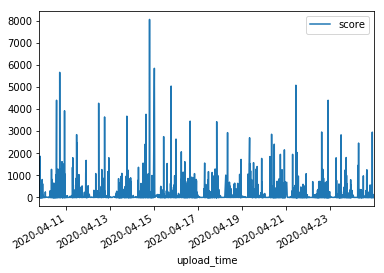

In [128]:
# response count during 2020-04-09 18:35:00 ~ 2020-04-24 23:59:00
time_score_df.plot()

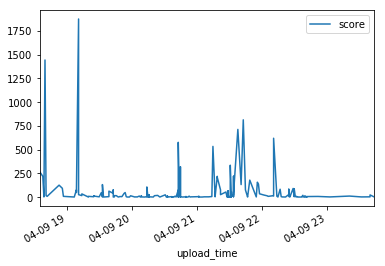

In [132]:
# response count during a day 2020-04-09
time_score_df.loc[(time_score_df.index >= '2020-04-09') & (time_score_df.index < '2020-04-10')].plot()

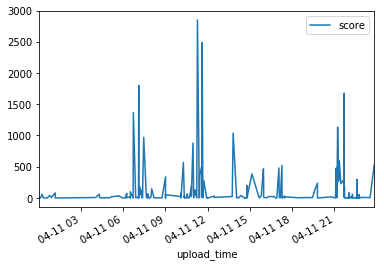

In [133]:
# response count during a day 2020-04-11
time_score_df.loc[(time_score_df.index >= '2020-04-11') & (time_score_df.index < '2020-04-12')].plot()

In [134]:
import surprise
from surprise import Reader
from surprise import Dataset

In [144]:
comment_df = pd.read_pickle("./comment.pkl")

In [145]:
comment_df = comment_df[['user_id', 'article_id']]
comment_df.head()

,user_id,article_id
0,dabo****,10825178
1,cooo****,10825178
2,axis****,10825178
3,hsma****,10825178
4,perf****,10825177


In [146]:
len(comment_df)

207178

In [148]:
# Number of comments user wrote
comment_df.groupby('user_id').agg('count').sort_values('article_id', ascending=False).head(10)

,article_id
user_id,
love****,906
blue****,606
park****,564
youn****,451
shin****,415
jung****,408
jang****,388
chan****,382
choi****,367


In [149]:
comment_df['write'] = 1
comment_df.head()

,user_id,article_id,write
0,dabo****,10825178,1
1,cooo****,10825178,1
2,axis****,10825178,1
3,hsma****,10825178,1
4,perf****,10825177,1


In [151]:
reader = Reader(rating_scale=(0.0,1.0))
data = Dataset.load_from_df(comment_df, reader)

In [ ]:
from surprise.model_selection import cross_validate
from surprise import SVD
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import BaselineOnly

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), KNNBaseline(), KNNBasic(), BaselineOnly()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

Estimating biases using als...


In [ ]:
from surprise.model_selection import train_test_split
from surprise import accuracy

In [ ]:
trainset, testset = train_test_split(data, test_size=0.25)